In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1, CNN_1D

In [4]:
# load data from sin dataset
data_save_dir = Path("../../data") / "gaussian_peak"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 21)
y_train shape: (4000, 3)
X_test shape: (1000, 21)
y_test shape: (1000, 3)


In [5]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

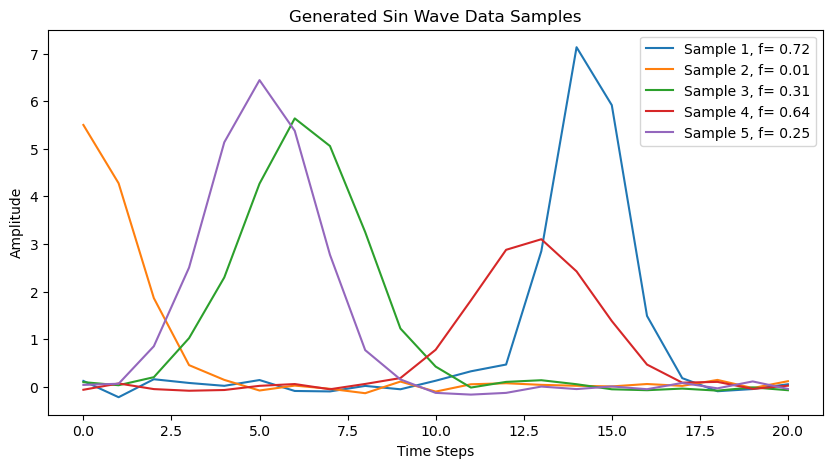

In [6]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

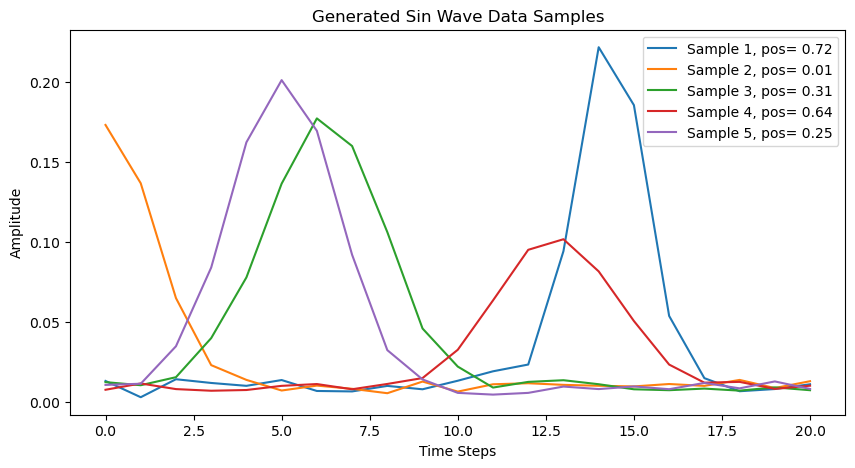

In [7]:
# normalize data to [0, 1]
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, pos= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

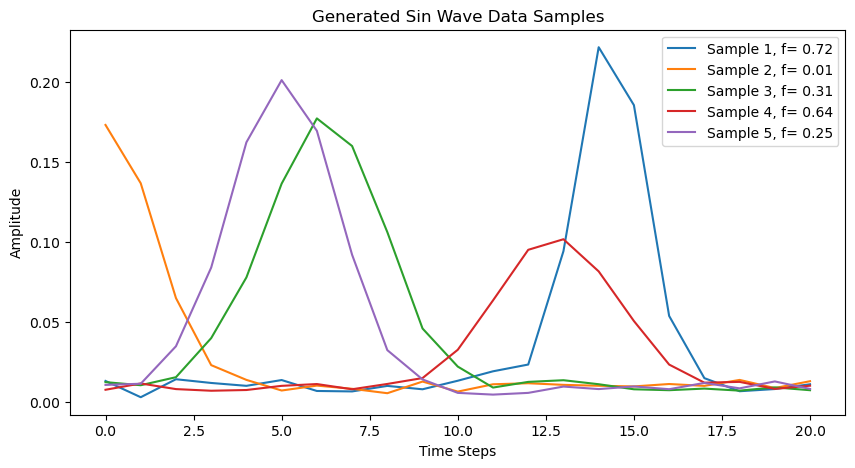

In [8]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [50]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 5),  # =1D kernel size
    "input_length": seq_len,
    "stride": 4,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 8,
}

CNN_classical = CNN_1D(hparams=hparams)

In [51]:
# change model to float64
CNN_classical = CNN_classical.double()

# number of trainable parameters
n_params = sum(p.numel() for p in CNN_classical.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_params}")

Number of trainable parameters: 169


In [52]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical.train()
optimizer = torch.optim.Adam(
    CNN_classical.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size, 0], dtype=torch.float64
        )
        batch_out = CNN_classical(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical.parameters()])
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.6665547443910145


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.44583346865169815


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.14724317611186152


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.12432252218725899


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.11341654448612133


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.12290390204010553


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.10073217718156749


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.09178926044163646


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.10087688395930175


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.07962117177657006


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.07670016650589737


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.06449425190183493


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.051248921526486135


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.03649905165448057


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.04432713204465751


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.024198524369009954


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.02581076464084569


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.03264284333618258


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.03382151248556101


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.031666593010836866


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.037150291630476506


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.01969519517159784


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.026725251981129444


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.023712826677040853


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train loss: 0.01553499293316254


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train loss: 0.016445343273073003


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train loss: 0.029477512466719258


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train loss: 0.01385952896635273


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train loss: 0.015007781775307765


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train loss: 0.01703526194285266


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train loss: 0.01791579432755329


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train loss: 0.02140100497187194


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train loss: 0.01845510828558168


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train loss: 0.015936178874912117


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train loss: 0.008704786183432676


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train loss: 0.01569183953875821


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train loss: 0.012667172814505384


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train loss: 0.01019716440269253


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train loss: 0.011730600767482382


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train loss: 0.007768147000455574


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train loss: 0.01336645079027841


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train loss: 0.017726150950228777


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train loss: 0.01341182209176012


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train loss: 0.00901679006656056


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train loss: 0.012835075367384572


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train loss: 0.011670126423468711


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train loss: 0.013140655511328148


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train loss: 0.009054623963363869


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train loss: 0.013013352630420772


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train loss: 0.008745039097045658
Final loss (MSE): 0.005393556196579
Final loss (RMSE): 0.07344083466695488


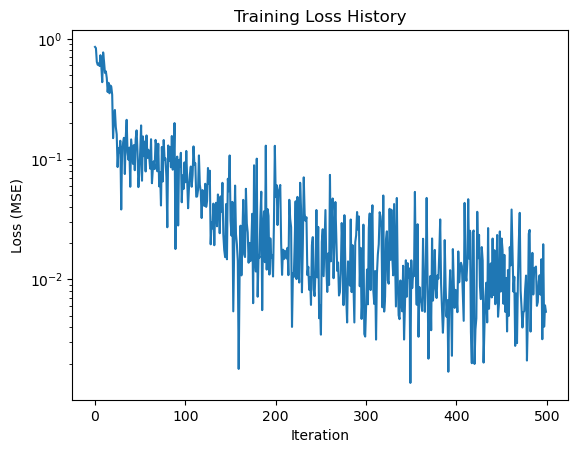

In [53]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [54]:
# test the model
CNN_classical.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(np.array(y_test[:,0]), dtype=torch.float64)
    predicted = CNN_classical(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp)
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.008579063986811323
Test loss (RMSE): 0.09262323675412841


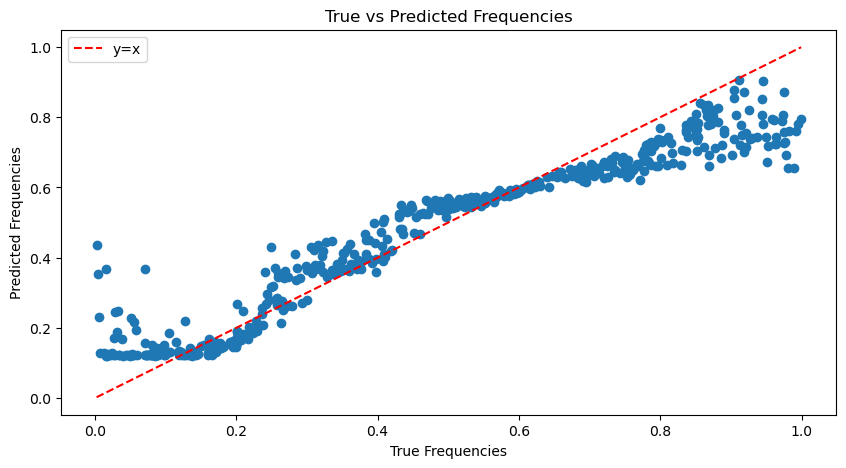

In [55]:
# plot the results
plt.figure(figsize=(10, 5))
plt.scatter(y_test_tmp, predicted.numpy())
# diagonal line
plt.plot([y_test_tmp.min(), y_test_tmp.max()], [y_test_tmp.min(), y_test_tmp.max()], 'r--', label='y=x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("True Frequencies")
plt.ylabel("Predicted Frequencies")
plt.legend()
plt.show()

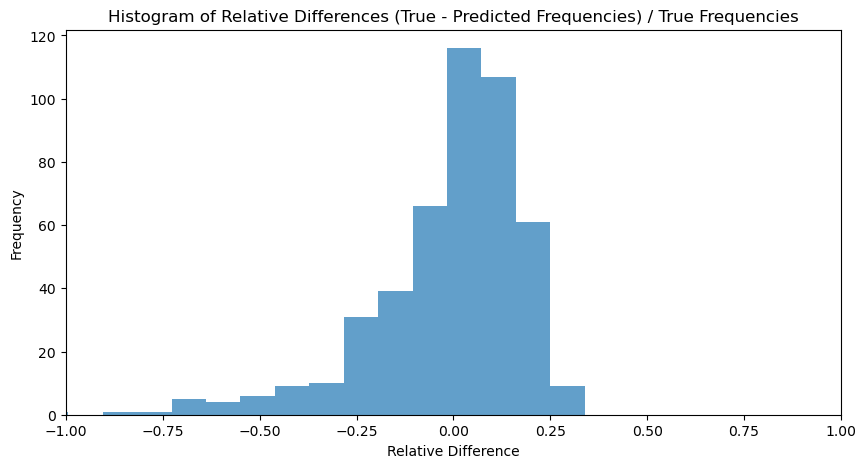

In [56]:
diffs = y_test[:,0] - y_pred_test
rel_diffs = diffs / y_test[:,0]  # relative differences
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(rel_diffs, bins=2000, alpha=0.7)
plt.title("Histogram of Relative Differences (True - Predicted Frequencies) / True Frequencies")
plt.xlabel("Relative Difference")
plt.ylabel("Frequency")
plt.xlim(-1, 1)  # limit x-axis to [-1, 1]
plt.show()

In [57]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_kernel_size_5_stride_4_gaussian_peak_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

# With Learned Channel Collapse

In [58]:
from source.NAHEA_CNN import CNN_1D_Learned_Channel_Collapse

In [67]:
seq_len = X_train.shape[1]
hparams = {
    "kernel_size": (n_features := 5),  # =1D kernel size
    "input_length": seq_len,
    "stride": 4,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
    "dropout": 0.1,  # dropout bate
    "conv1_channels": 7,
}

CNN_classical_2 = CNN_1D_Learned_Channel_Collapse(hparams=hparams)
CNN_classical_2 = CNN_classical_2.double()

In [68]:
n_params = sum(p.numel() for p in CNN_classical_2.parameters() if p.requires_grad)
print(f"Number of learned parameters: {n_params}")

Number of learned parameters: 171


In [69]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
CNN_classical_2.train()
optimizer = torch.optim.Adam(
    CNN_classical_2.parameters(), lr=0.01, weight_decay=1e-5
)
params_hist = [copy.deepcopy(p) for p in CNN_classical_2.parameters()]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64).reshape(
            -1, 1, seq_len
        )
        y_batch = torch.tensor(
            y_train[i : i + batch_size, 0], dtype=torch.float64
        )
        batch_out = CNN_classical_2(x_batch)  # (batch_size, 1, seq_len)
        # predicted = torch.stack([bo["output"] for bo in batch_out])
        predicted = batch_out
        loss = loss_fn(predicted.squeeze(1), y_batch)
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append([copy.deepcopy(p) for p in CNN_classical_2.parameters()])
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss (MSE): {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 train loss: 0.7462295225467067


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 train loss: 0.2495374606304146


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 train loss: 0.14361520264912442


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 train loss: 0.12775086277272046


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 train loss: 0.12459849558761316


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 train loss: 0.1061901902796765


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 train loss: 0.10247845867395414


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 train loss: 0.07158656620376211


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 train loss: 0.0734094093267724


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 train loss: 0.05464171277388925


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 train loss: 0.055956491451452886


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 train loss: 0.03555073101595275


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 train loss: 0.039894839511873295


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 train loss: 0.02324180315306444


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 train loss: 0.021890317532405744


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 train loss: 0.020384166713514344


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 train loss: 0.021933590419662384


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 train loss: 0.025469459030700154


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 train loss: 0.029295792580411574


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 train loss: 0.025438490949874364


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 train loss: 0.02273616816846445


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 train loss: 0.016172037136262377


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 train loss: 0.01609369743736391


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 train loss: 0.019756467028877414


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 train loss: 0.01704026715389847


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 train loss: 0.015253651016793301


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 train loss: 0.02201742319045321


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 train loss: 0.012823575710309565


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 train loss: 0.01796009116561594


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 train loss: 0.01845695042865466


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 train loss: 0.015315825965762798


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 train loss: 0.021229091548822892


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 train loss: 0.012363394594182413


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 train loss: 0.013558279709107637


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 train loss: 0.015551278476840142


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 train loss: 0.012559348078797128


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 train loss: 0.016656127429563176


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 train loss: 0.013372332037842258


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 train loss: 0.011909480956998678


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 train loss: 0.01791211119729786


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 train loss: 0.01612613886176865


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 train loss: 0.02335368380248526


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 train loss: 0.017185904185562297


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 train loss: 0.013734118900033473


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 train loss: 0.013366045956668793


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 train loss: 0.016824109734884827


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 train loss: 0.014255827284542083


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 train loss: 0.009836821237579969


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 train loss: 0.016730446567634043


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 train loss: 0.011771051546222
Final loss (MSE): 0.0023621699673818746
Final loss (RMSE): 0.04860216011024484


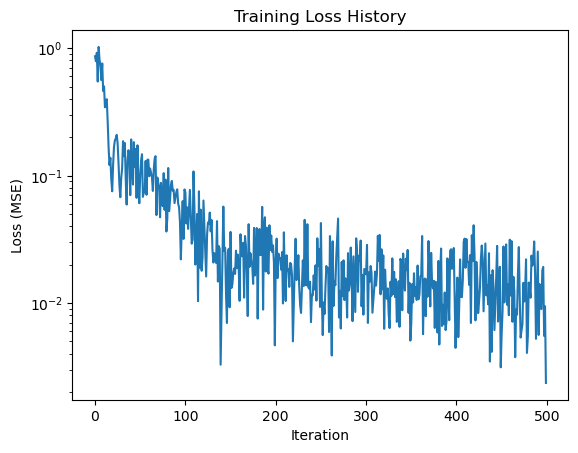

In [70]:
plt.plot(loss_hist)
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.show()

In [72]:
# test the model
CNN_classical_2.eval()
y_pred_test = []
with torch.no_grad():
    x_test = torch.tensor(X_test, dtype=torch.float64).reshape(-1, 1, seq_len)  # (batch_size, 1, seq_len)
    y_test_tmp = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
    predicted = CNN_classical_2(x_test).squeeze(1)  # (batch_size, 1, seq_len)
    y_pred_test.append(predicted.numpy())
    test_loss = loss_fn(predicted, y_test_tmp[:, 0])
    print(f"Test loss (MSE): {test_loss.item()}")
    print(f"Test loss (RMSE): {np.sqrt(test_loss.item())}")
y_pred_test = np.concatenate(y_pred_test, axis=0)

Test loss (MSE): 0.007053995784943836
Test loss (RMSE): 0.08398806930120394


In [73]:
import pickle
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/classical_CNN_kernel_size_5_stride_4_gaussian_peak_leanred_ch_collapse_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            test_loss.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )